In [1]:
%reset -f
from pythonrc import *

In [2]:
time_step = 0.01


# tunnel.extra_attributes['rate_limit'] = 0.1
# voithschneider_port.extra_attributes['rate_limit'] = 0.1
# voithschneider_starboard.extra_attributes['rate_limit'] = 0.1

del voithschneider_port.extra_attributes["reference_angle"]
del voithschneider_starboard.extra_attributes["reference_angle"]


actuators = [tunnel, voithschneider_port, voithschneider_starboard]
for a in actuators:
    a.extra_attributes["rate_limit"] = 0.1

force_torque_components = [
    skadipy.allocator.ForceTorqueComponent.X,
    skadipy.allocator.ForceTorqueComponent.Y,
    skadipy.allocator.ForceTorqueComponent.N,
]

allocators = []
gamma = [0.1, 0.1, 0.1]
mu = [0.1, 0.1, 0.1]
rho = [0.1, 1.0, 10.0]
zeta = [1.0, 1.0, 1.0]
lambda_p = [0.9, 0.9, 0.9]

markdown_table = generate_markdown_table(
    gamma, mu, rho, zeta, lambda_p,
)
display(Markdown(markdown_table))

| | $\gamma$ | $\mu$ | $\rho$ | $\zeta$ | $\lambda_i$ |
|--|-------|----|-----|------|----------|
| Run 0| 0.1 | 0.1 | 0.1 | 1.0 | 0.9 |
| Run 1| 0.1 | 0.1 | 1.0 | 1.0 | 0.9 |
| Run 2| 0.1 | 0.1 | 10.0 | 1.0 | 0.9 |


In [3]:


for g, m, r, l, z in zip(gamma, mu, rho, lambda_p, zeta):

    allocators.append(
        skadipy.allocator.reference_filters.MinimumMagnitudeAndAzimuth(
            actuators=actuators,
            force_torque_components=force_torque_components,
            control_barrier_function=skadipy.safety.ControlBarrierFunctionType.ABSOLUTE,
            gamma=g,
            mu=m,
            rho=r,
            zeta=z,
            time_step=time_step,
            lambda_=l,
        )
    )


(<Figure size 800x800 with 3 Axes>,
 array([<Axes: xlabel='Time [s]', ylabel='$F_x$ [N]'>,
        <Axes: xlabel='Time [s]', ylabel='$F_y$ [N]'>,
        <Axes: xlabel='Time [s]', ylabel='$M_z$ [N]'>], dtype=object))

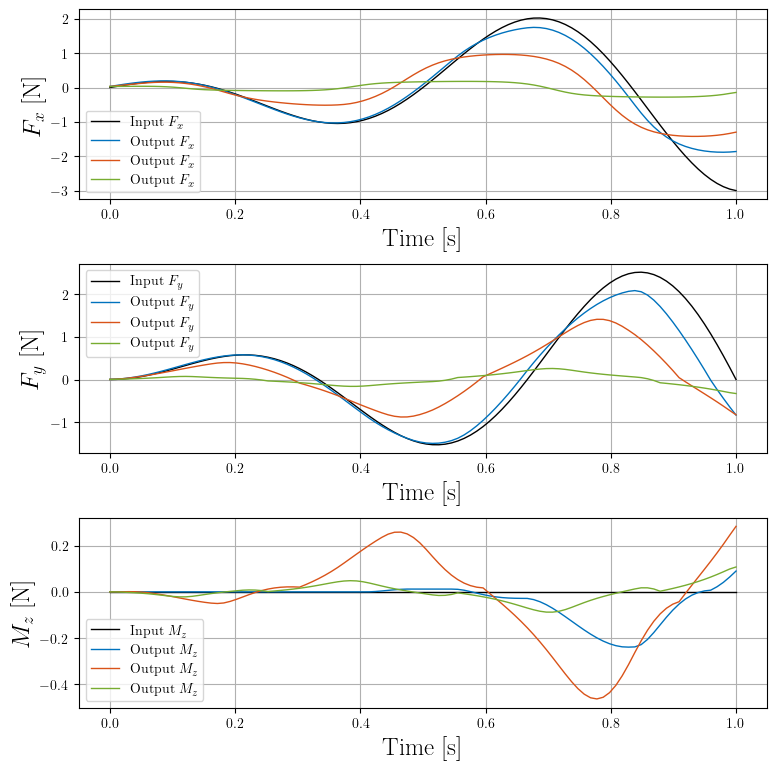

In [4]:
data = generate_spiral_dataset(num_points=100, num_turns=1.5, k=3)

tau_cmd = np.concatenate((data, np.zeros((np.shape(data)[0], 4))), axis=1)

d_tau_cmd = np.gradient(tau_cmd, axis=0) / time_step

xi_hist, theta_hist, tau_hist = run_tests(
    tau_cmd=tau_cmd,
    d_tau_cmd=d_tau_cmd,
    allocators=allocators,
)
plot_histories(tau_cmd=tau_cmd, tau_alloc=tau_hist, dt=time_step)

(<Figure size 800x800 with 2 Axes>,
 array([<Axes: xlabel='$F_x$ [N]', ylabel='$F_y$ [N]'>,
        <Axes: xlabel='Time [s]', ylabel='$M_z$ [Nm]'>], dtype=object))

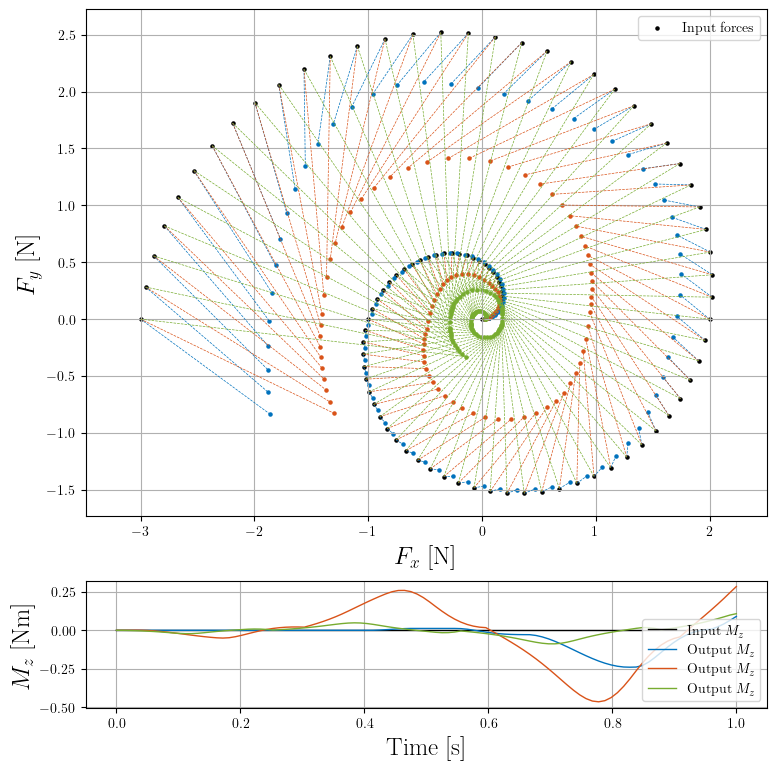

In [5]:
plot_2d_allocation(tau_cmd, allocators, tau_hist, dt=time_step)

(<Figure size 800x800 with 3 Axes>,
 array([<Axes: xlabel='Time [s]', ylabel='Tunnel [N]'>,
        <Axes: xlabel='Time [s]', ylabel='Port [N]'>,
        <Axes: xlabel='Time [s]', ylabel='Starboard [N]'>], dtype=object))

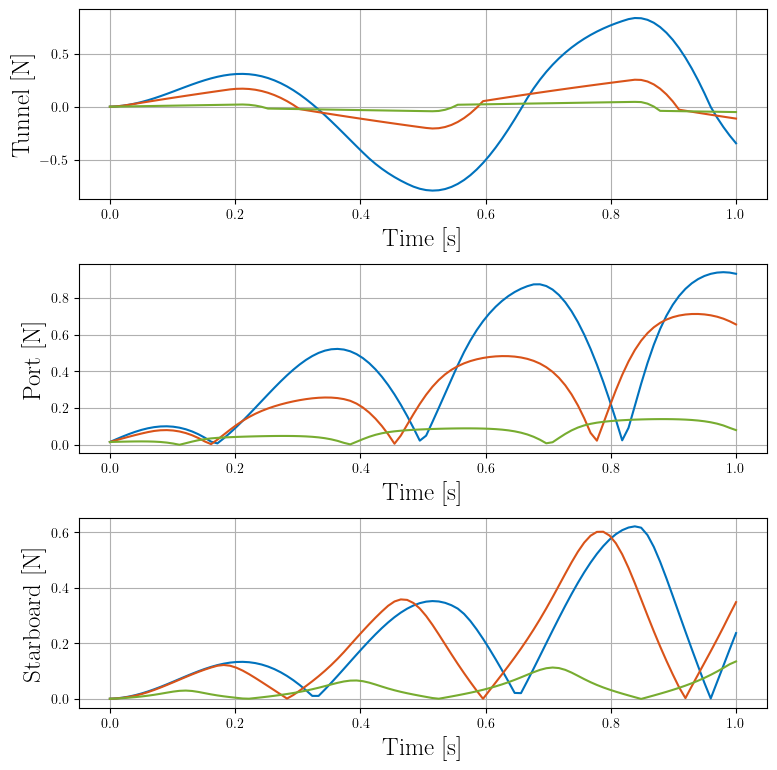

In [6]:
plot_thruster_forces(xi_hist, dt=time_step)

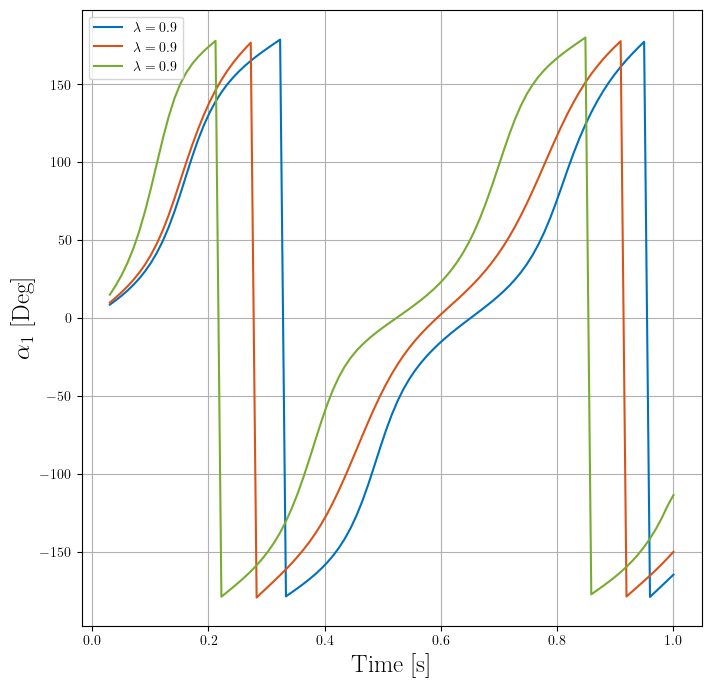

In [7]:
plot_angles(xi_hist, dt=time_step)

l = []
for i in lambda_p:
    l.append(f"$\lambda = {i}$")

plt.legend(l)
plt.grid(True)

(<Figure size 800x800 with 3 Axes>,
 array([<Axes: xlabel='Time [s]', ylabel='$\\theta_2$'>,
        <Axes: xlabel='Time [s]', ylabel='$\\theta_1$'>,
        <Axes: xlabel='Time [s]', ylabel='$\\theta_2$'>], dtype=object))

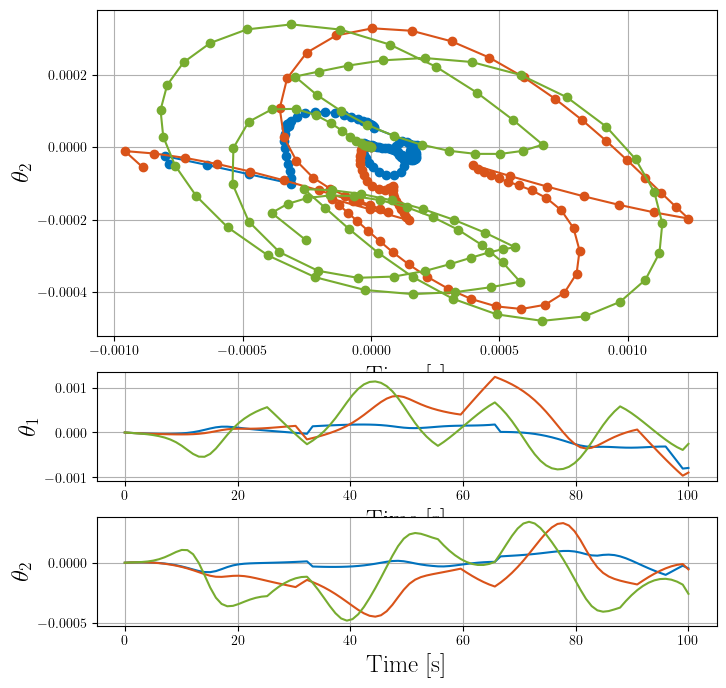

In [8]:
plot_theta_histories(theta_hist=theta_hist)

In [9]:
save_mat(
    filename="data/017.mat",
    dt=time_step,
    inputs=tau_cmd,
    xi=xi_hist,
    thetas=theta_hist,
    outputs=tau_hist,
    zeta=zeta,
    rho=rho,
    gamma=gamma,
    mu=mu,
    lambda_p=lambda_p,
    thruster=voithschneider_port
)